In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def view_random_image(data):
    rand_cat = random.sample(list(train_data['category'].unique()),1)
    rand_img = random.sample(list(data[data['category']==rand_cat[0]]['image_path']),1)

    img = mpimg.imread(rand_img[0])
    plt.imshow(img)
    plt.title(rand_cat[0])
    plt.axis('off')

    print(f'Image shape: {img.shape}')

    return img

def loss_curves(cnn):
    loss = cnn.history['loss']
    val_loss = cnn.history['val_loss']

    accuracy = cnn.history['accuracy']
    val_accuracy = cnn.history['val_accuracy']

    epochs = range(len(cnn.history['loss']))

    plt.plot(epochs, loss, label= "training_loss")
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('loss')
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label= "training_accuracy")
    plt.plot(epochs, val_accuracy, label='validation_accuracy')
    plt.title('accuracy')
    plt.xlabel("epochs")
    plt.legend()


## Load Train/Test Set

In [5]:
dir = '../data/food-101'
# Load the category labels
labels_file = dir+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = dir+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)

# Load the testing dataset
test_file = dir+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(dir, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)

(75750, 4)
(25250, 4)


Image shape: (512, 512, 3)


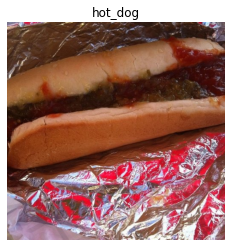

In [7]:
x = view_random_image(train_data)

## Preprocess Data

In [73]:
# Parameters for model training
input_shape = (224, 224, 3)
batch_size = 32

train_gen = ImageDataGenerator()

train_gen_aug = ImageDataGenerator(
                               rotation_range= 20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)

test_gen = ImageDataGenerator(validation_split=0.15)


In [75]:
# load image categories and filepaths from dataframe
tf_train_data = train_gen.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)
tf_train_data_aug = train_gen_aug.flow_from_dataframe(train_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, classes=labels)

tf_valid_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, subset='validation')
tf_test_data = test_gen.flow_from_dataframe(test_data,x_col='image_path',y_col='category',target_size=(224,224),batch_size=batch_size, subset='training')


Found 75750 validated image filenames belonging to 101 classes.
Found 75750 validated image filenames belonging to 101 classes.
Found 3787 validated image filenames belonging to 101 classes.
Found 21463 validated image filenames belonging to 101 classes.


## CNN Modeling

### EfficientNetB0

In [79]:
checkpoint_fp = '../models/eff_net/checkpoints/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_fp,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_Accuracy',
    mode='max',
    save_freq='epoch')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [77]:
effb0_model = tf.keras.applications.EfficientNetB0(include_top=False)
effb0_model.trainable=False

inputs = layers.Input(shape= input_shape, name='input_layer')

#x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = effb0_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(labels)) (x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy'])

hist_effb0_1 = model.fit(tf_train_data,
                        epochs=4,
                        steps_per_epoch=len(tf_train_data),
                        validation_data=tf_valid_data,
                        validation_steps=len(tf_valid_data),
                        callbacks=model_checkpoint_callback
                        )

Epoch 1/4
2368/2368 [==============================] - 284s 118ms/step - loss: 1.8232 - Accuracy: 0.5555 - val_loss: 1.4241 - val_Accuracy: 0.6295
Epoch 2/4
2368/2368 [==============================] - 270s 114ms/step - loss: 1.2936 - Accuracy: 0.6660 - val_loss: 1.2956 - val_Accuracy: 0.6493
Epoch 3/4
2368/2368 [==============================] - 271s 114ms/step - loss: 1.1418 - Accuracy: 0.7038 - val_loss: 1.2540 - val_Accuracy: 0.6636
Epoch 4/4
2368/2368 [==============================] - 271s 114ms/step - loss: 1.0457 - Accuracy: 0.7260 - val_loss: 1.2508 - val_Accuracy: 0.6607


In [78]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 73s 109ms/step - loss: 1.0387 - Accuracy: 0.7189


[1.0387483835220337, 0.7188650369644165]

In [ ]:
model.save('../models/base_model')

### FIne Tune Efficient Net ~Top 25 layers

In [45]:
for layer_number, layer in enumerate(effb0_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_12 False
1 rescaling_11 False
2 normalization_11 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [46]:
effb0_model.trainable=True

for layer in effb0_model.layers[:-25]:
    layer.trainable = False

# drop learning rate as to not change weights too much via fine tuning
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])



In [48]:
hist_effb0_1_fine_tune25 = model.fit(tf_train_data,
                         epochs=8, # fine tune for an additional 4 epochs
                         steps_per_epoch=len(tf_train_data),
                         validation_data=tf_test_data,
                         validation_steps=int(0.15*len(tf_test_data)),
                         initial_epoch=hist_effb0_1.epoch[-1], # start training from last trained epoch in this case training starts at epoch 4
                         callbacks=model_checkpoint_callback
                         )

Epoch 4/8
2368/2368 [==============================] - 283s 118ms/step - loss: 0.8760 - Accuracy: 0.7660 - val_loss: 0.9877 - val_Accuracy: 0.7315
Epoch 5/8
2368/2368 [==============================] - 279s 118ms/step - loss: 0.6724 - Accuracy: 0.8185 - val_loss: 0.9562 - val_Accuracy: 0.7460
Epoch 6/8
2368/2368 [==============================] - 279s 118ms/step - loss: 0.5114 - Accuracy: 0.8618 - val_loss: 1.0299 - val_Accuracy: 0.7344
Epoch 7/8
2368/2368 [==============================] - 281s 119ms/step - loss: 0.3748 - Accuracy: 0.9006 - val_loss: 1.0631 - val_Accuracy: 0.7333
Epoch 8/8
2368/2368 [==============================] - 284s 120ms/step - loss: 0.2595 - Accuracy: 0.9319 - val_loss: 1.1419 - val_Accuracy: 0.7336


In [49]:
results = model.evaluate(tf_test_data)
results

790/790 [==============================] - 86s 109ms/step - loss: 1.1672 - Accuracy: 0.7285


[1.1672430038452148, 0.7285148501396179]

### Tune on all layers

In [80]:
effb0_model.trainable=True

# drop learning rate as to not change weights too much via fine tuning
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['Accuracy'])

In [81]:
hist_effb0_1_fine_tune_all = model.fit(tf_train_data,
                                     epochs=104, # fine tune for an additional 4 epochs
                                     steps_per_epoch=len(tf_train_data),
                                     validation_data=tf_valid_data,
                                     validation_steps=len(tf_valid_data),
                                     initial_epoch=hist_effb0_1.epoch[-1], # start training from last trained epoch in this case training starts at epoch 4
                                     callbacks=[model_checkpoint_callback, callback]
                                     )

Epoch 4/104
2368/2368 [==============================] - 441s 183ms/step - loss: 0.8861 - Accuracy: 0.7598 - val_loss: 0.9299 - val_Accuracy: 0.7449
Epoch 5/104
2368/2368 [==============================] - 433s 183ms/step - loss: 0.5540 - Accuracy: 0.8463 - val_loss: 1.0146 - val_Accuracy: 0.7293
Epoch 6/104
2368/2368 [==============================] - 434s 183ms/step - loss: 0.3193 - Accuracy: 0.9083 - val_loss: 1.0784 - val_Accuracy: 0.7336
Epoch 7/104
2368/2368 [==============================] - 434s 183ms/step - loss: 0.1722 - Accuracy: 0.9478 - val_loss: 1.2179 - val_Accuracy: 0.7354


In [82]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 75s 111ms/step - loss: 0.9904 - Accuracy: 0.7761


[0.9904047250747681, 0.7760797739028931]

In [83]:
model.save('../models/eff_net/model_full_tune')

INFO:tensorflow:Assets written to: ../models/eff_net/model_full_tune\assets


C:\Users\Ivan\anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Sample load model weights for best performing val_accuracy during training

In [84]:
model.load_weights(checkpoint_fp)

In [85]:
results = model.evaluate(tf_test_data)
results

671/671 [==============================] - 73s 109ms/step - loss: 0.8133 - Accuracy: 0.7766


[0.8133400082588196, 0.7765922546386719]

### ConvNeXt